In [1]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import sklearn
from time import time

# 커스텀 모듈 import
from infer_target import InferTarget
from encodingModules.lstm import LSTMAE
from encodingModules.graph import GAE
from encodingModules.transformer import TAE

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2025-12-15 05:16:34.859568: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-15 05:16:34.955761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-15 05:16:34.955813: E external/local_xla/xla/stream_execut

In [3]:
gas_cluster = InferTarget('gas', 'cluster', n_clusters=5)
gas_test = InferTarget('gas', 'test', n_clusters=5)

In [5]:
elec = pd.read_csv('/root/workspace/AMI/InferProj/data/elec_clustering_test.csv', index_col=0).sum(axis=1)
hotwater = pd.read_csv('/root/workspace/AMI/InferProj/data/hotwater_clustering_test.csv', index_col=0).sum(axis=1)
water = pd.read_csv('/root/workspace/AMI/InferProj/data/water_clustering_test.csv', index_col=0).sum(axis=1)
gas = pd.read_csv('/root/workspace/AMI/InferProj/data/gas_clustering_test.csv', index_col=0).sum(axis=1)
elec.index = pd.to_datetime(elec.index)
hotwater.index = pd.to_datetime(hotwater.index)
water.index = pd.to_datetime(water.index)
gas.index = pd.to_datetime(gas.index)

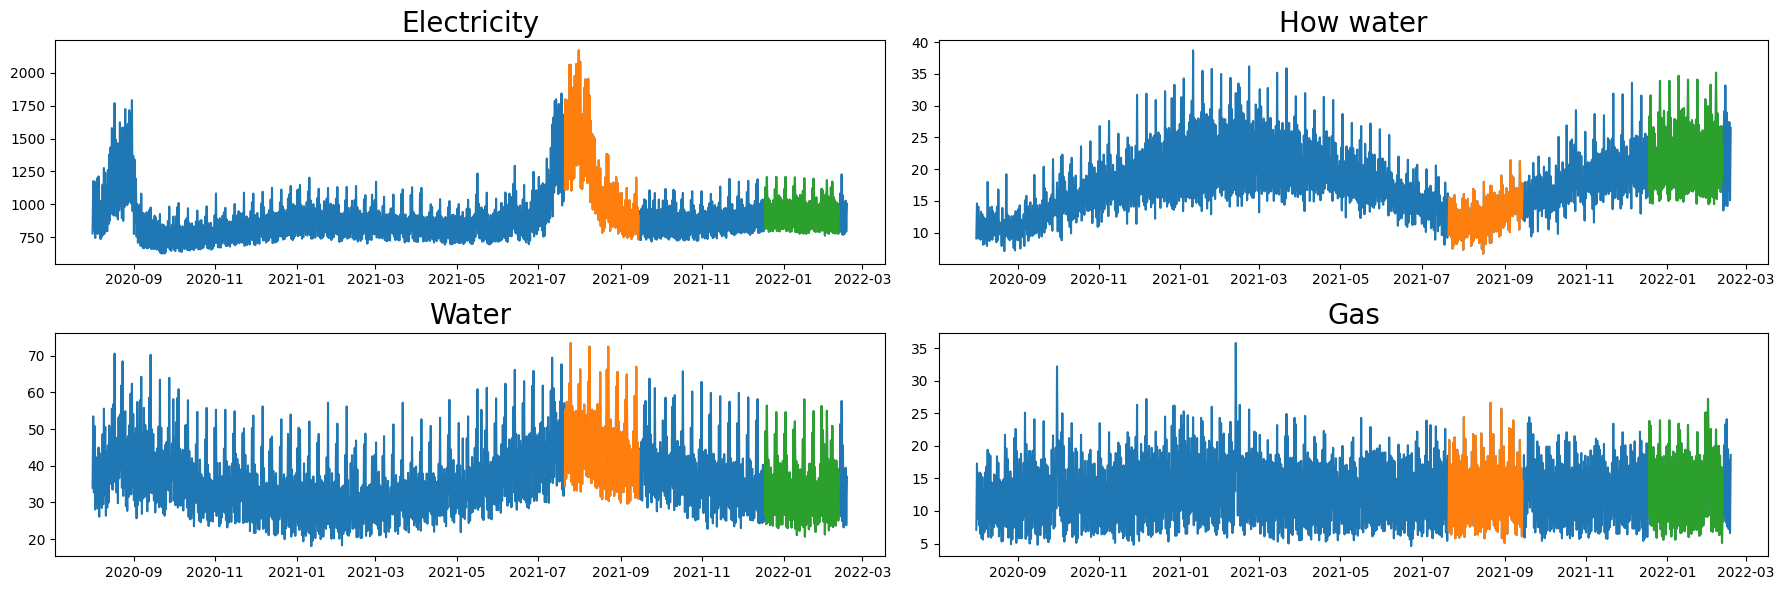

In [27]:
plt.figure(figsize=(18,6))
for i, j in enumerate(zip([elec, hotwater, water, gas], ["Electricity","How water","Water","Gas"])):
    energy, name = j
    energy = energy.resample(rule='12H').sum()
    energy_1 = energy[1008-300:1008+112-300]
    energy_2 = energy[1008:1008+112]    
    plt.subplot(2,2,i+1)
    plt.plot(energy)
    plt.plot(energy_1)    
    plt.plot(energy_2)    
    plt.title(name, fontsize=20)
plt.tight_layout()
plt.savefig('load_comparison_between_2intervals.png')
plt.show()

In [13]:
elec = elec.resample(rule='12H').sum()

time
2020-08-01 00:00:00     779.7
2020-08-01 12:00:00    1176.3
2020-08-02 00:00:00     804.3
2020-08-02 12:00:00    1173.9
2020-08-03 00:00:00     745.7
                        ...  
2022-02-15 12:00:00    1017.1
2022-02-16 00:00:00     780.2
2022-02-16 12:00:00    1028.3
2022-02-17 00:00:00     794.4
2022-02-17 12:00:00    1005.1
Freq: 12H, Length: 1132, dtype: float64

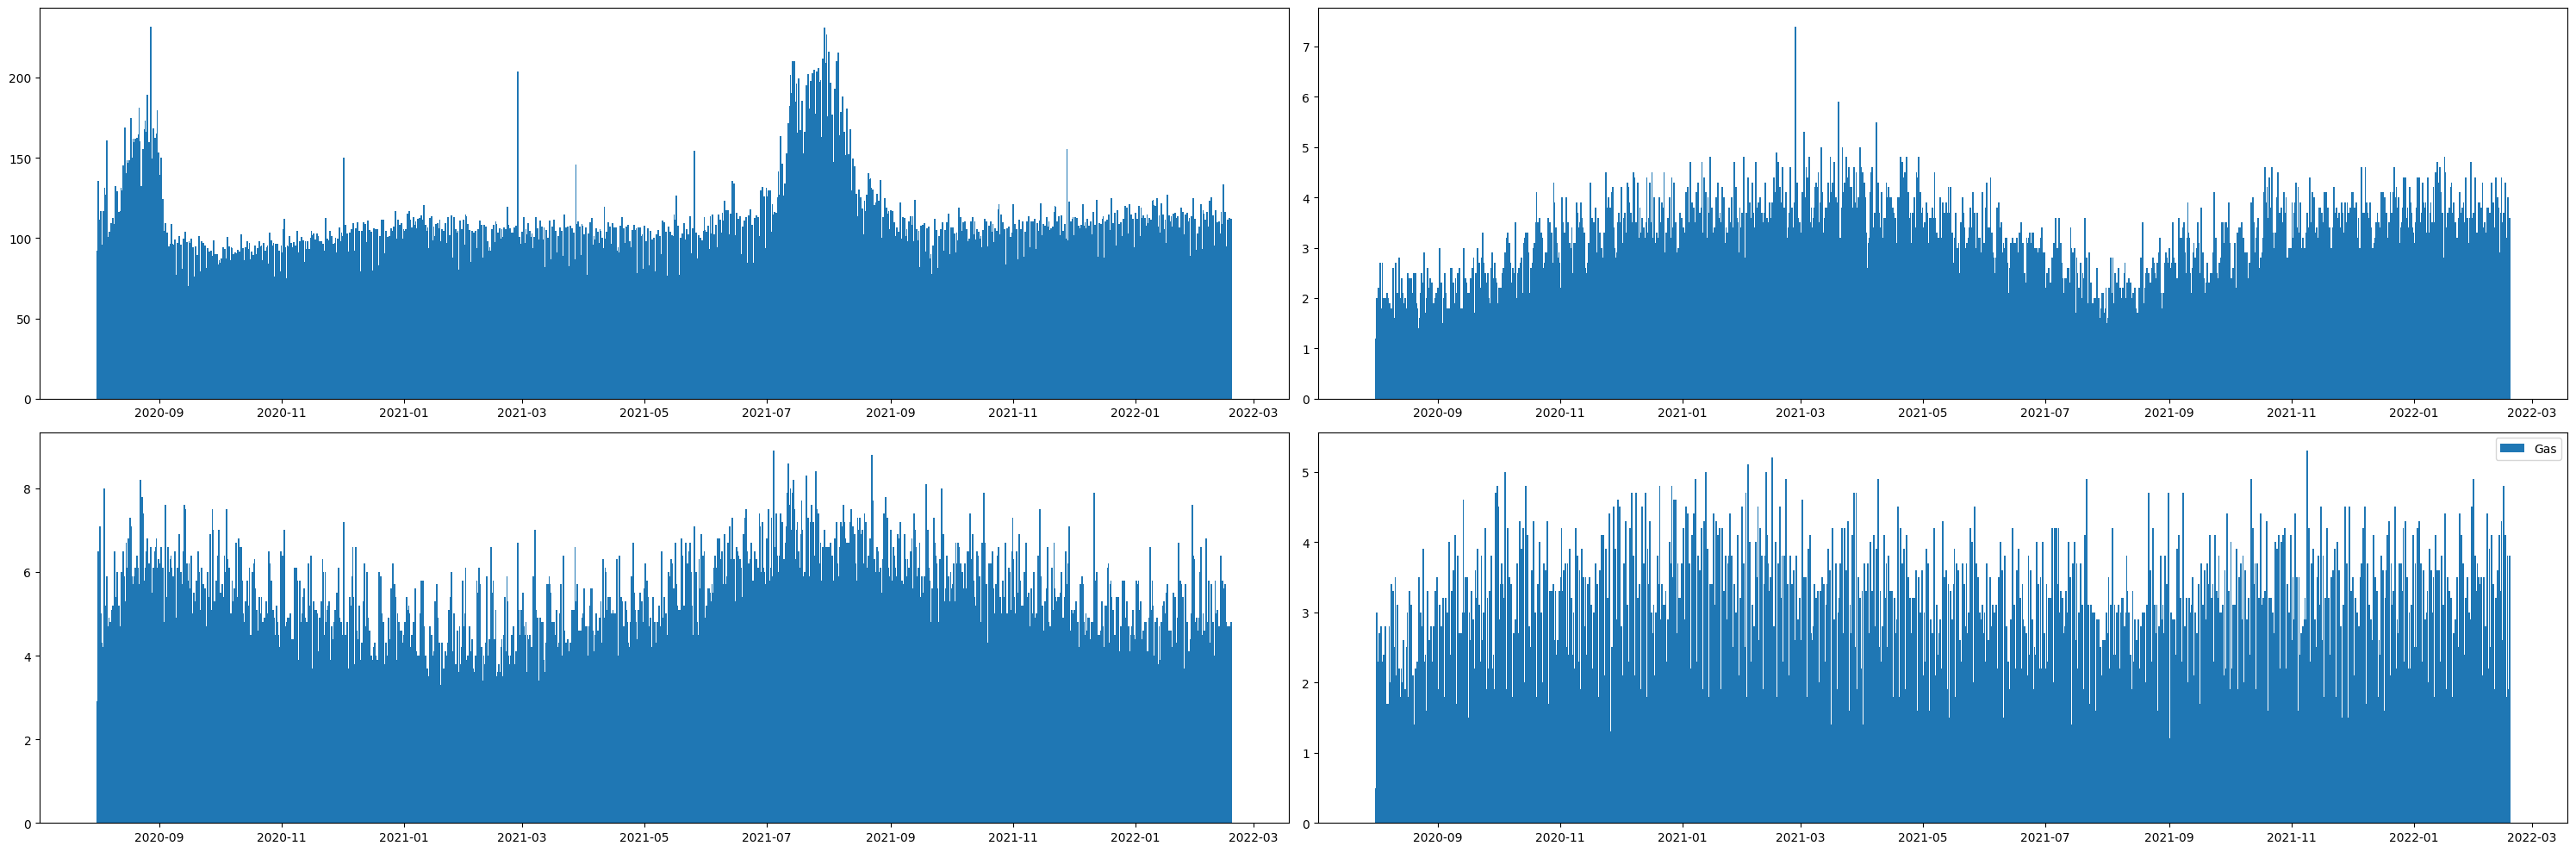

In [9]:
plt.figure(figsize=(30,10))
plt.subplot(2,2,1)
plt.bar(elec.index, elec)
plt.bar(elec.index, elec)
plt.bar(elec.index, elec)
plt.subplot(2,2,2)
plt.bar(hotwater.index, hotwater)
plt.bar(hotwater.index, hotwater)
plt.bar(hotwater.index, hotwater)
plt.subplot(2,2,3)
plt.bar(water.index, water)
plt.bar(water.index, water)
plt.bar(water.index, water)
plt.subplot(2,2,4)
plt.bar(gas.index, gas)
plt.bar(gas.index, gas)
plt.bar(gas.index, gas)
plt.legend()
plt.tight_layout()
plt.show()

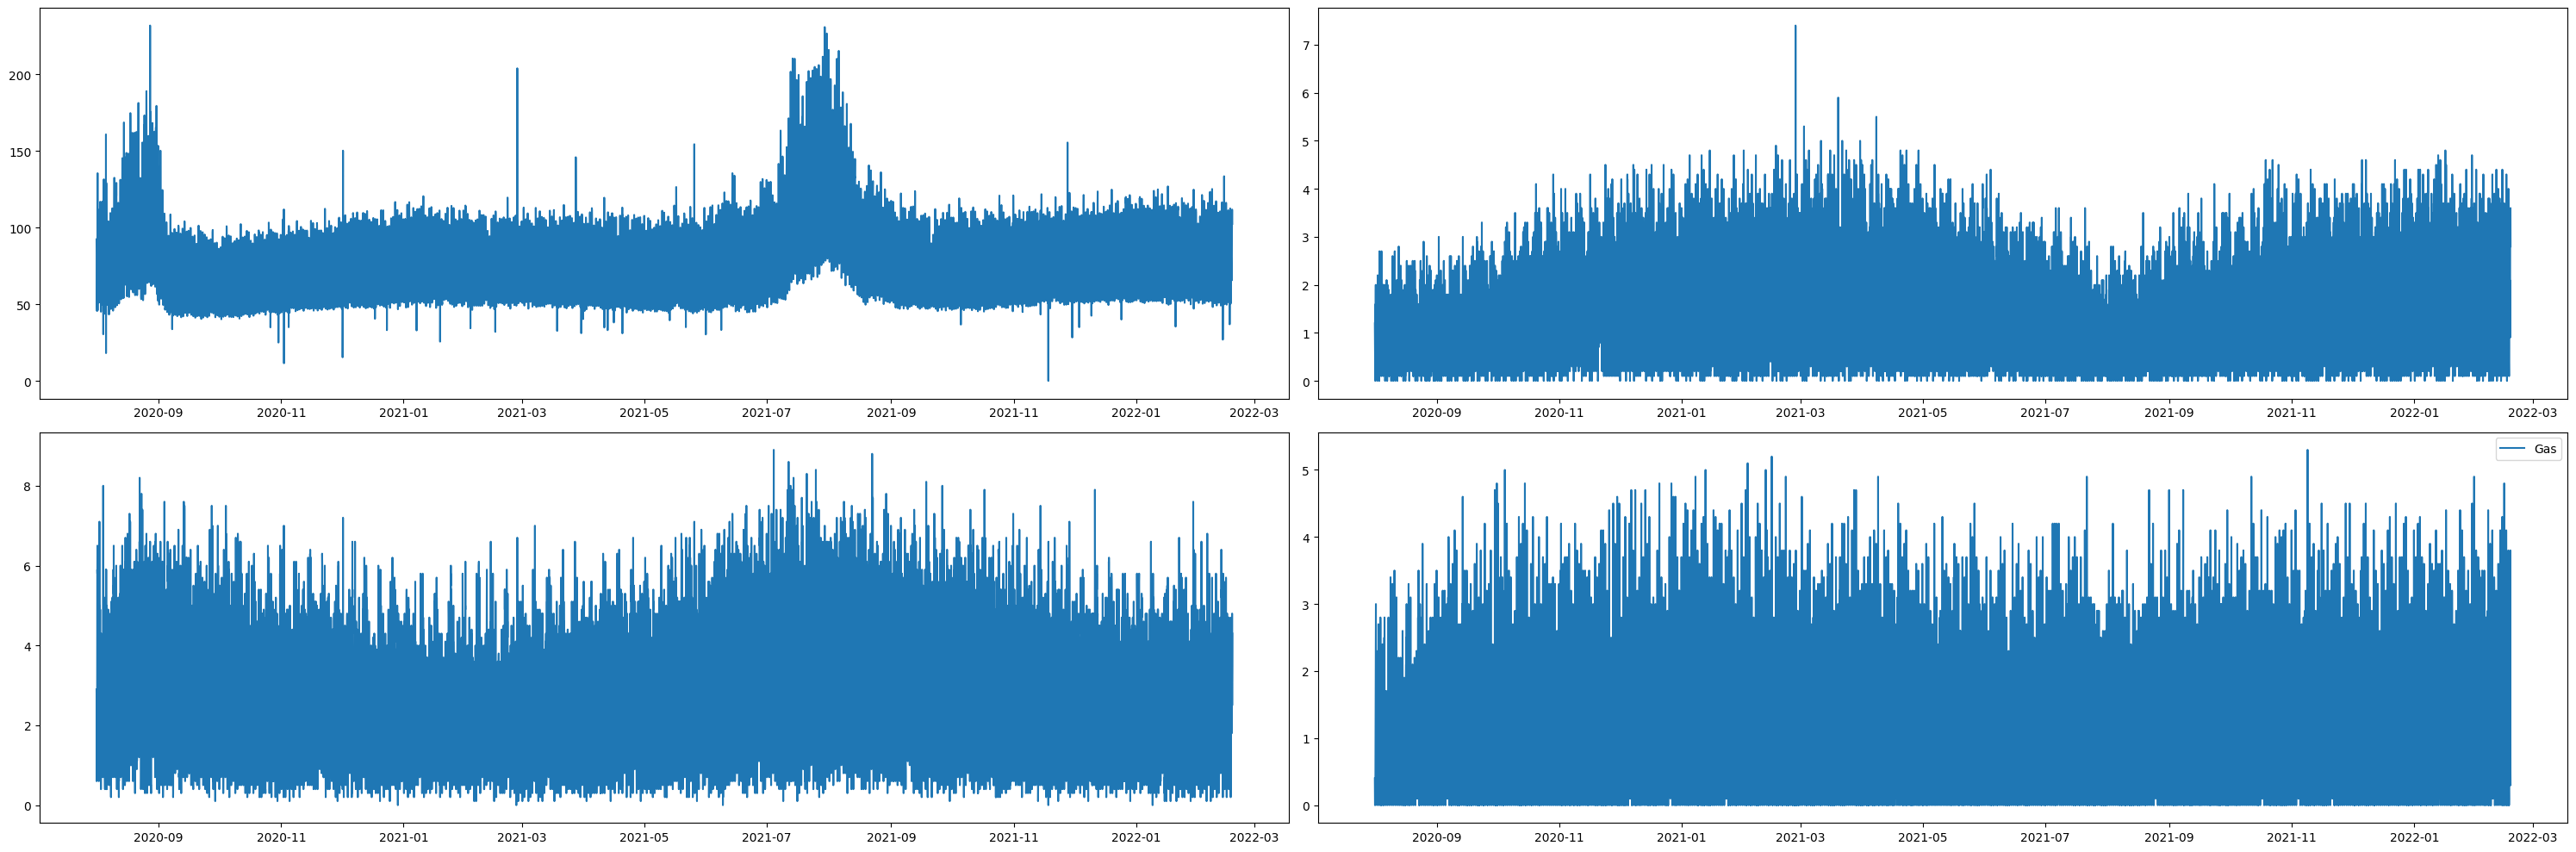

In [7]:
plt.figure(figsize=(30,10))
plt.subplot(2,2,1)
plt.plot(elec)
plt.plot(elec)
plt.plot(elec)

plt.subplot(2,2,2)
plt.plot(hotwater, label="Hot water")
plt.plot(hotwater, label="Hot water")
plt.plot(hotwater, label="Hot water")
plt.subplot(2,2,3)
plt.plot(water, label="Water")
plt.plot(water, label="Water")
plt.plot(water, label="Water")
plt.subplot(2,2,4)
plt.plot(gas, label="Gas")
plt.plot(gas, label="Gas")
plt.plot(gas, label="Gas")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# 결과 데이터프레임 생성
cluster_methods = ['kmedoids', 'kmeans', 'agglomerative', 'gmm']
df_cluster = pd.DataFrame(columns=cluster_methods)
df_test = pd.DataFrame(columns=cluster_methods)

In [4]:
# AVG
avg_cluster_mean = gas_cluster.regionA_average()
avg_test_mean = gas_test.regionA_average()

print('\n[AVG]')
print(f'Cluster MAE mean: {avg_cluster_mean}')
print(f'Test MAE mean: {avg_test_mean}')

Total : 0.06838405936630676
Total : 0.06777701006980316

[AVG]
Cluster MAE mean: 0.06838405936630676
Test MAE mean: 0.06777701006980316


/root/workspace/AMI/InferProj/infer_target.py:61: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  np.tile(self.target_total[self.region_A][self.start_idx:self.end_idx].mean(axis=1)[:, np.newaxis], (1, len(self.region_B))))
/root/workspace/AMI/InferProj/infer_target.py:61: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  np.tile(self.target_total[self.region_A][self.start_idx:self.end_idx].mean(axis=1)[:, np.newaxis], (1, len(self.region_B))))


In [5]:
true_c, infer_c, mae_c = gas_cluster.predict_target_knn()
true_t, infer_t, mae_t = gas_test.predict_target_knn()

In [6]:
true_c.shape

(56, 233)

In [9]:
# RAE
total_cluster = []
total_test = []
for cluster_method in cluster_methods:
    mae_cluster = []
    mae_test = []
    for i in range(101, 105):
        cluster, si = gas_cluster.cluster_by_RAE(cluster_method,i)
        true, infer, mae = gas_cluster.predict_target(cluster, si)
        mae_cluster.append(mae)
        cluster, si = gas_test.cluster_by_RAE(cluster_method,i)
        true, infer, mae = gas_test.predict_target(cluster, si)
        mae_test.append(mae)
    
    print(f'[{cluster_method}]')
    print('cluster MAE mean:',(c_mean:=np.array(mae_cluster).mean()).round(10))
    print('cluster MAE std:',(c_std:=np.array(mae_cluster).std()).round(10))
    print('test MAE mean:',(t_mean:=np.array(mae_test).mean()).round(10))
    print('test MAE std:',(t_std:=np.array(mae_test).std()).round(10))
    print()
    
    total_cluster.append(c_mean)
    total_test.append(t_mean)

df_cluster.loc['RAE'] = total_cluster
df_test.loc['RAE'] = total_test

(56, 233)
(56, 233)
(56, 233)
(56, 233)
(56, 233)


KeyboardInterrupt: 

In [5]:
# GAE
total_cluster = []
total_test = []
for cluster_method in cluster_methods:
    mae_cluster = []
    mae_test = []
    for i in range(1, 4):
        cluster, si = gas_cluster.cluster_by_GAE(cluster_method,i)
        mae = gas_cluster.predict_target(cluster, si)
        mae_cluster.append(mae)
        cluster, si = gas_test.cluster_by_GAE(cluster_method,i)
        mae = gas_test.predict_target(cluster, si)
        mae_test.append(mae)
    
    print(f'[{cluster_method}]')
    print('cluster MAE mean:',(c_mean:=np.array(mae_cluster).mean()).round(10))
    print('cluster MAE std:',(c_std:=np.array(mae_cluster).std()).round(10))
    print('test MAE mean:',(t_mean:=np.array(mae_test).mean()).round(10))
    print('test MAE std:',(t_std:=np.array(mae_test).std()).round(10))
    print()
    
    total_cluster.append(c_mean)
    total_test.append(t_mean)

df_cluster.loc['GAE'] = total_cluster
df_test.loc['GAE'] = total_test

[kmedoids]
cluster MAE mean: 0.0660893214
cluster MAE std: 0.0004496361
test MAE mean: 0.0653634263
test MAE std: 0.0005629335

[kmeans]
cluster MAE mean: 0.06554175
cluster MAE std: 0.0003644188
test MAE mean: 0.0647926493
test MAE std: 0.000379221

[agglomerative]
cluster MAE mean: 0.0654827897
cluster MAE std: 0.0005504064
test MAE mean: 0.0647767943
test MAE std: 0.0007724644

[gmm]
cluster MAE mean: 0.0655553122
cluster MAE std: 0.0002965253
test MAE mean: 0.0650095478
test MAE std: 0.0003093272



In [7]:
# TAE
total_cluster = []
total_test = []
for cluster_method in cluster_methods:
    mae_cluster = []
    mae_test = []
    for i in range(101, 105):
        cluster, si = gas_cluster.cluster_by_TAE(cluster_method,i)
        mae = gas_cluster.predict_target(cluster, si)
        mae_cluster.append(mae)
        cluster, si = gas_test.cluster_by_TAE(cluster_method,i)
        mae = gas_test.predict_target(cluster, si)
        mae_test.append(mae)
    
    print(f'[{cluster_method}]')
    print('cluster MAE mean:',(c_mean:=np.array(mae_cluster).mean()).round(10))
    print('cluster MAE std:',(c_std:=np.array(mae_cluster).std()).round(10))
    print('test MAE mean:',(t_mean:=np.array(mae_test).mean()).round(10))
    print('test MAE std:',(t_std:=np.array(mae_test).std()).round(10))
    print()
    
    total_cluster.append(c_mean)
    total_test.append(t_mean)

df_cluster.loc['TAE'] = total_cluster
df_test.loc['TAE'] = total_test

[kmedoids]
cluster MAE mean: 0.0677196373
cluster MAE std: 0.0006122463
test MAE mean: 0.0639751606
test MAE std: 0.0003281447

[kmeans]
cluster MAE mean: 0.0668527168
cluster MAE std: 0.0004193278
test MAE mean: 0.0639232066
test MAE std: 0.000289805

[agglomerative]
cluster MAE mean: 0.0674039836
cluster MAE std: 0.0004268852
test MAE mean: 0.0650656213
test MAE std: 0.0005975527

[gmm]
cluster MAE mean: 0.0686338705
cluster MAE std: 0.0002862519
test MAE mean: 0.0661530245
test MAE std: 0.0008212191



In [14]:
df_cluster.to_csv('/root/workspace/AMI/InferProj/exp_result/gas_cluster.csv')
df_test.to_csv('/root/workspace/AMI/InferProj/exp_result/gas_test.csv')

In [13]:
n_clusters=8
gas_cluster = InferTarget('gas', 'cluster', n_clusters=n_clusters)
gas_test = InferTarget('gas', 'test', n_clusters=n_clusters)
elec = pd.read_csv('/root/workspace/AMI/InferProj/data/elec_clustering_test.csv', index_col=0).sum(axis=1)
hotwater = pd.read_csv('/root/workspace/AMI/InferProj/data/hotwater_clustering_test.csv', index_col=0).sum(axis=1)
water = pd.read_csv('/root/workspace/AMI/InferProj/data/water_clustering_test.csv', index_col=0).sum(axis=1)
gas = pd.read_csv('/root/workspace/AMI/InferProj/data/gas_clustering_test.csv', index_col=0).sum(axis=1)
elec.index = pd.to_datetime(elec.index)
hotwater.index = pd.to_datetime(hotwater.index)
water.index = pd.to_datetime(water.index)
gas.index = pd.to_datetime(gas.index)
# elec = elec.resample(rule='12H').sum()

# 결과 데이터프레임 생성
cluster_methods = ['kmedoids', 'kmeans', 'agglomerative', 'gmm']
df_cluster = pd.DataFrame(columns=cluster_methods)
df_test = pd.DataFrame(columns=cluster_methods)

# AVG
avg_cluster_mean = gas_cluster.regionA_average()
avg_test_mean = gas_test.regionA_average()

print('\n[AVG]')
print(f'Cluster MAE mean: {avg_cluster_mean}')
print(f'Test MAE mean: {avg_test_mean}')

# RAE
total_cluster = []
total_test = []
for cluster_method in cluster_methods:
    mae_cluster = []
    mae_test = []
    for i in range(101, 102):
        start = time()
        cluster, si = gas_cluster.cluster_by_RAE(cluster_method,i)
        print('time taken for cluster', cluster_method, 'iteration', i, ':', (time()-start), 'seconds')
        mae = gas_cluster.predict_target(cluster, si)[-1]
        mae_cluster.append(mae)
        cluster, si = gas_test.cluster_by_RAE(cluster_method,i)
        mae = gas_test.predict_target(cluster, si)[-1]
        mae_test.append(mae)
    
    print(f'\n[RAE - {cluster_method}]')
    print('cluster MAE mean:',(c_mean:=np.array(mae_cluster).mean()).round(10))
    print('cluster MAE std:',(c_std:=np.array(mae_cluster).std()).round(10))
    print('test MAE mean:',(t_mean:=np.array(mae_test).mean()).round(10))
    print('test MAE std:',(t_std:=np.array(mae_test).std()).round(10))
    print()
    
    total_cluster.append(c_mean)
    total_test.append(t_mean)

df_cluster.loc['RAE'] = total_cluster
df_test.loc['RAE'] = total_test

# GAE
total_cluster = []
total_test = []
for cluster_method in cluster_methods:
    mae_cluster = []
    mae_test = []
    for i in range(1, 2):
        start = time()
        cluster, si = gas_cluster.cluster_by_GAE(cluster_method,i)
        print('time taken for cluster', cluster_method, 'iteration', i, ':', (time()-start), 'seconds')
        mae = gas_cluster.predict_target(cluster, si)[-1]
        mae_cluster.append(mae)
        cluster, si = gas_test.cluster_by_GAE(cluster_method,i)
        mae = gas_test.predict_target(cluster, si)[-1]
        mae_test.append(mae)
    
    print(f'\n[GAE - {cluster_method}]')
    print('cluster MAE mean:',(c_mean:=np.array(mae_cluster).mean()).round(10))
    print('cluster MAE std:',(c_std:=np.array(mae_cluster).std()).round(10))
    print('test MAE mean:',(t_mean:=np.array(mae_test).mean()).round(10))
    print('test MAE std:',(t_std:=np.array(mae_test).std()).round(10))
    print()
    
    total_cluster.append(c_mean)
    total_test.append(t_mean)

df_cluster.loc['GAE'] = total_cluster
df_test.loc['GAE'] = total_test

# TAE
total_cluster = []
total_test = []
for cluster_method in cluster_methods:
    mae_cluster = []
    mae_test = []
    for i in range(101, 102):
        start = time()
        cluster, si = gas_cluster.cluster_by_TAE(cluster_method,i)
        print('time taken for cluster', cluster_method, 'iteration', i, ':', (time()-start), 'seconds')
        start = time()
        mae = gas_cluster.predict_target(cluster, si)[-1]
        print('time taken for prediction', cluster_method, 'iteration', i, ':', (time()-start), 'seconds')
        mae_cluster.append(mae)
        cluster, si = gas_test.cluster_by_TAE(cluster_method,i)
        mae = gas_test.predict_target(cluster, si)[-1]
        mae_test.append(mae)
    
    print(f'\n[TAE - {cluster_method}]')
    print('cluster MAE mean:',(c_mean:=np.array(mae_cluster).mean()).round(10))
    print('cluster MAE std:',(c_std:=np.array(mae_cluster).std()).round(10))
    print('test MAE mean:',(t_mean:=np.array(mae_test).mean()).round(10))
    print('test MAE std:',(t_std:=np.array(mae_test).std()).round(10))
    print()
    
    total_cluster.append(c_mean)
    total_test.append(t_mean)

df_cluster.loc['TAE'] = total_cluster
df_test.loc['TAE'] = total_test

df_cluster.to_csv(f'/root/workspace/AMI/InferProj/exp_result/gas_cluster_{n_clusters}.csv')
df_test.to_csv(f'/root/workspace/AMI/InferProj/exp_result/gas_test_{n_clusters}.csv')

df_cluster, df_test

/root/workspace/AMI/InferProj/infer_target.py:59: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  np.tile(self.target_total[self.region_A][self.start_idx:self.end_idx].mean(axis=1)[:, np.newaxis], (1, len(self.region_B))))
/root/workspace/AMI/InferProj/infer_target.py:59: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  np.tile(self.target_total[self.region_A][self.start_idx:self.end_idx].mean(axis=1)[:, np.newaxis], (1, len(self.region_B))))


Total : 0.06838405936630676
Total : 0.06777701006980316

[AVG]
Cluster MAE mean: 0.06838405936630676
Test MAE mean: 0.06777701006980316
time taken for cluster kmedoids iteration 101 : 0.39669346809387207 seconds

[RAE - kmedoids]
cluster MAE mean: 0.0671556693
cluster MAE std: 0.0
test MAE mean: 0.0667787644
test MAE std: 0.0

time taken for cluster kmeans iteration 101 : 0.42313623428344727 seconds

[RAE - kmeans]
cluster MAE mean: 0.0666147884
cluster MAE std: 0.0
test MAE mean: 0.066672734
test MAE std: 0.0

time taken for cluster agglomerative iteration 101 : 0.3193998336791992 seconds

[RAE - agglomerative]
cluster MAE mean: 0.0673465682
cluster MAE std: 0.0
test MAE mean: 0.0663927747
test MAE std: 0.0

time taken for cluster gmm iteration 101 : 1.0926268100738525 seconds

[RAE - gmm]
cluster MAE mean: 0.0666525434
cluster MAE std: 0.0
test MAE mean: 0.0668637676
test MAE std: 0.0

time taken for cluster kmedoids iteration 1 : 3.71191668510437 seconds

[GAE - kmedoids]
cluster MA

(     kmedoids    kmeans  agglomerative       gmm
 RAE  0.067156  0.066615       0.067347  0.066653
 GAE  0.066507  0.066164       0.066502  0.066265
 TAE  0.065847  0.067716       0.066921  0.067627,
      kmedoids    kmeans  agglomerative       gmm
 RAE  0.066779  0.066673       0.066393  0.066864
 GAE  0.065779  0.065407       0.065905  0.065486
 TAE  0.064923  0.065154       0.066101  0.065995)